# <center> "Bayesian Methods for Media Mix Modeling with Carryover and Shape Effects" <br> Reproducing simulation results

#### 5.1 Simulation Setting and Prior Distributions

The simulated data set contains 2 years of weekly data, sales, three media and one control variable
(price). Media variables are generated by adding white noise to a sinusoidal seasonality with one
year as a period; the control variable is generated as an ARIMA time series. For each media, the
spend is scaled to be from 0 to 1 for convenience. Table 1 contains the parameters used in the model
in (7) to generate sales as the response variable. Here we assume no transformation is used on the
response variable. Figure 4 shows the time series plots of the sales and the media spend. Due to
the data generation mechanism, weekly spend of all media have the same marginal distribution.
Figure 4d shows the histogram of weekly spend of Media 1, which is quite spread out from 0 to 1.
The media variables are also very weakly correlated with a correlation of 0.09.

#### Features

- date (day)
- media channels (x3) - white noise with sinusoidal seasonality with one year as a period
- control variable - ARIMA time series
- sales - response variable 

In [188]:
import pandas as pd
import numpy as np
import os
import math
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import MinMaxScaler, normalize
import scipy

from statsmodels.tsa import arima_process as arima

In [2]:
from wma import geoDecay, delayed_adstock, carryover, beta_hill, response_additive

## Carryover effect

$ x_{t,m}^{*} = addstock(x_{t-L+1,m,...,x_{t,m}; w_m,L}) = \frac{\sum_{l=1}^{L-1}{w_m(l)\cdot x_{t-l,m}}}{\sum_{l=1}^{L-1}{w_m(l)}}  \\ $
 - 
$ a)\ w_m^{g}(l,\alpha_m) = \alpha_m^{l} \text{   geometric decay} \\ \\ b)\ w_m^{d}(l,\alpha_m,\theta_m) = \alpha_m^{(l-\theta_m)^{2}} \text{   delayed decay} \\ l = 0,...,L-1 ,\ 0<\alpha_m <1, \ 0<\theta_m<L-1 $

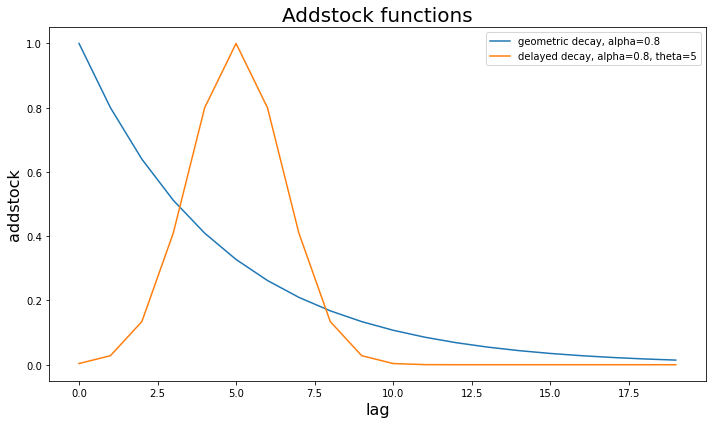

In [3]:
alpha = 0.8
theta = 5
L=20
x = np.linspace(start=0, stop=19, num=L)

plt.figure(figsize=(10,6))
plt.plot(x,geoDecay(alpha=alpha, L=L)[::-1], label = 'geometric decay, alpha={}'.format(alpha))
plt.plot(x,delayed_adstock(alpha=alpha, theta=theta, L=L)[::-1], 
         label='delayed decay, alpha={}, theta={}'.format(alpha,theta))
plt.legend()
plt.title('Addstock functions', fontsize=20)
plt.xlabel('lag',fontsize=16)
plt.ylabel('addstock', fontsize=16)
plt.tight_layout()

# Shape effect

$ \beta_m \cdot Hill(x_{t,m}^{*},\kappa_m,S_m) = \beta_m - \frac{\kappa_m^{S_m}\cdot \beta_m}{x_{t,m}^{S_m} +\kappa_m^{S_m} } \\ $

In [4]:
beta = [0.3,0.3925,0.3,0.3,0.8,1.144]
S = [1,0.748,2,0.5,2,1.867]
K = [0.5,0.95,0.5,0.5,1.5,2]
colors = ['k','k','r','g','b','b']
lines = ['-','--','-','-','-','--']
labels = ['β={} S={} K={}'.format(b,s,k) for (b,s,k) in zip(beta,S,K)]

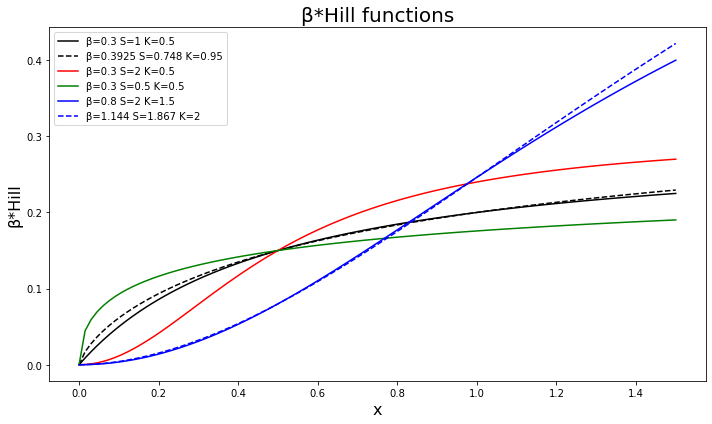

In [5]:
x = np.linspace(start=0, stop=1.5, num=100)

plt.figure(figsize=(10,6))
for i in range(len(beta)):
    b = beta[i]
    s = S[i]
    k = K[i]
    plt.plot(x, beta_hill(x, s, k, b), label=labels[i], color=colors[i], linestyle=lines[i])

plt.legend()
plt.title('β*Hill functions', fontsize=20)
plt.xlabel('x',fontsize=16)
plt.ylabel('β*Hill', fontsize=16)
plt.tight_layout()


״The parameters of βHill are essentially unidentifiable in some scenarios.." (e.g - black and blue curves ) <br>

# Simulate data

## Defs (channels)

In [206]:
start = 0
end = 52 *2
duration = int(end-start)
intervals = 1
period = 52 
phase_shift = 0
vertical_shift = 0
amplitude = 1

mvn_mue = [0,0,0]
mvn_sig = 1.5
mvn_cor = 0.09

In [207]:
time = np.arange(start, end, intervals)

In [208]:
def yearly_period(x, amplitude=amplitude,vertical_shift=vertical_shift,period=period, phase_shift=phase_shift):
    return amplitude * np.sin((2*math.pi / period) * (x-phase_shift)) + vertical_shift

## media channels
### 0.09 correlation

In [209]:
media_channels = yearly_period(time, amplitude=amplitude,
                               vertical_shift=vertical_shift,period=period, phase_shift=0)

In [210]:
# create covariance matrix for media channels
cov = np.zeros((3,3)) + mvn_cor
np.fill_diagonal(cov,mvn_sig)

In [211]:
### add gaussian noise
random.seed(0)

noise_1, noise_2, noise_3 = np.random.multivariate_normal(mvn_mue, cov, int(duration/intervals)).T

scaler = MinMaxScaler()

# media channel 1
media_ch1 = media_channels + noise_1
media_ch1 = np.expand_dims(media_ch1, axis=1)
media_ch1 = scaler.fit_transform(media_ch1)

# media channel 2
media_ch2 = media_channels + noise_2
media_ch2 = np.expand_dims(media_ch2, axis=1)
media_ch2 = scaler.fit_transform(media_ch2)

# media channel 1
media_ch3 = media_channels + noise_3
media_ch3 = np.expand_dims(media_ch3, axis=1)
media_ch3 = scaler.fit_transform(media_ch3)


### Control variable - price (ARIMA)

In [221]:
np.random.seed(12345)
arparams = np.array([.75, -.25])
maparams = np.array([.65, .35])
ar = np.r_[1, -arparams] # add zero-lag and negate
ma = np.r_[1, maparams] # add zero-lag
price = arima.arma_generate_sample(ar, ma, duration)
price = np.expand_dims(price, axis=1)
price = scaler.fit_transform(price)

### Raw Data

In [222]:
dates = np.expand_dims(time,axis=1)
df = (pd.DataFrame(data=np.hstack((dates, media_ch1, media_ch2, media_ch3, price)),
      columns=['date','ch1','ch2','ch3','price']))
print(df.shape)
df.head(2)

(104, 5)


,date,ch1,ch2,ch3,price
0,0.0,0.767462,0.514301,0.396790,0.583359
1,1.0,0.610914,0.446465,0.225103,0.618564


In [223]:
media_ch1.shape

(104, 1)

## Response surface
<br>
<br>
$ y_t = \tau + \sum_{m=1}^{M}{\beta_m \cdot Hill(x_{t,m}^{*},\kappa_m,S_m)} + \sum_{c=1}^{C}{\gamma_c \cdot z_{t,c}} + \epsilon_t \\ $





Combining the Carryover and the Shape Effect <br>
Since media spend ineach time period is relatively small compared to the cumulative spend across multiple time periods, <br> 
I apply the shape transformation after the adstock transformation

### Prior parameter selection:

In [224]:
ch1_dict = {'alpha':0.6, 'theta':5, 'L':13, 'decay':'delayed','S':1, 'K':0.2, 'beta':0.8}
ch2_dict = {'alpha':0.8, 'theta':3, 'L':13, 'decay':'delayed','S':2, 'K':0.2, 'beta':0.6}
ch3_dict = {'alpha':0.8, 'theta':4, 'L':13, 'decay':'delayed','S':2, 'K':0.2, 'beta':0.3}
channel_params = {'ch1':ch1_dict, 'ch2':ch2_dict, 'ch3':ch3_dict}
tau = 4
lamb = [-0.5]
var_eps = 0.05**2

treatment_columns = ['ch1', 'ch2', 'ch3']
control_columns = ['price']
date_col = 'date'

simulate = True

In [225]:
sales = response_additive(df, treatment_columns, control_columns, channel_params,
                  date_col=date_col, tau=tau, lamb=lamb, simulate=simulate, eps=var_eps)
sales.shape

(104,)

### Plotting

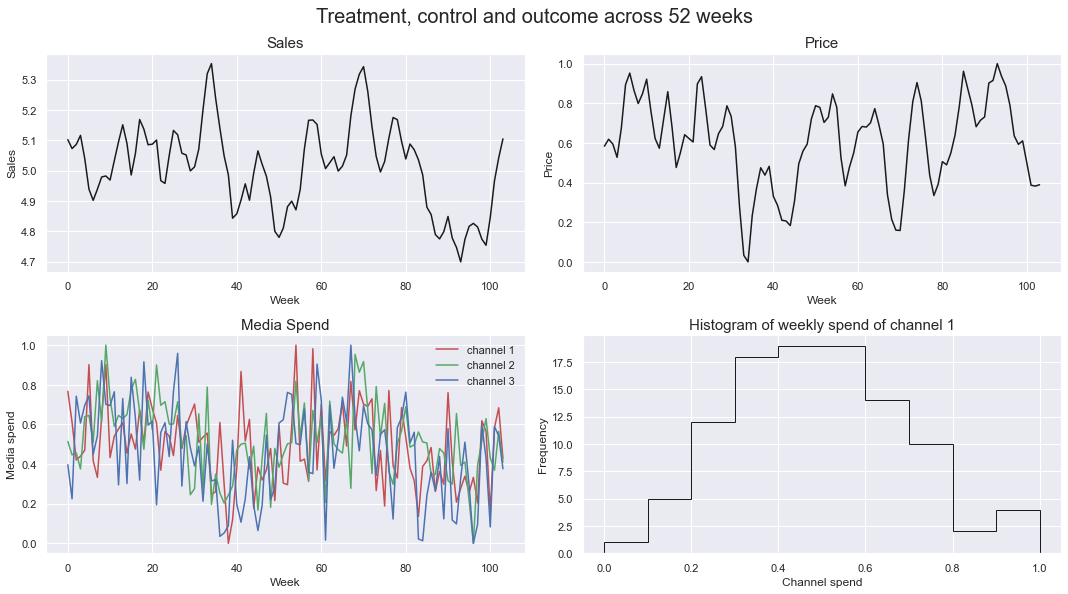

In [226]:
fig, axes = plt.subplots(2,2, figsize=(15, 8))

axes[0,0].set_xlabel('Week',fontsize=12)
axes[0,0].set_ylabel('Sales',fontsize=12)
axes[0,0].set_title('Sales',fontsize=15)
axes[0,0].plot(time,sales, color='k')

axes[0,1].plot(time,price, color='k')
axes[0,1].set_xlabel('Week', fontsize=12)
axes[0,1].set_ylabel('Price',fontsize=12)
axes[0,1].set_title('Price',fontsize=15)

axes[1,0].plot(time,media_ch1,color='r')
axes[1,0].plot(time,media_ch2,color='g')
axes[1,0].plot(time,media_ch3,color='b')

axes[1,0].set_xlabel('Week',fontsize=12)
axes[1,0].set_ylabel('Media spend',fontsize=12)
axes[1,0].legend(['channel 1','channel 2','channel 3'], loc=0)
axes[1,0].set_title('Media Spend',fontsize=15)

axes[1,1].hist(media_ch1, bins=10,  histtype='step', color='k')
axes[1,1].set_xlabel('Channel spend',fontsize=12)
axes[1,1].set_ylabel('Frequency',fontsize=12)
axes[1,1].set_title('Histogram of weekly spend of channel 1', fontsize=15)


fig.suptitle('Treatment, control and outcome across {} weeks'.format(period),fontsize=20, y=1.03 )
fig.tight_layout()

<bound method Figure.tight_layout of <Figure size 360x288 with 2 Axes>>

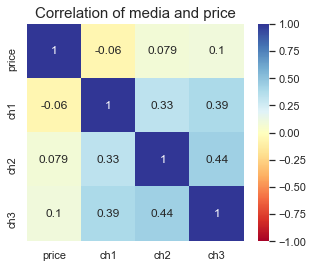

In [227]:
import seaborn as sns

f, ax = plt.subplots(figsize=(5, 4))
corr = df[['price', 'ch1','ch2','ch3']].corr()
# sns.set(font_scale=1)
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap='RdYlBu',
            square=True, ax=ax, annot=True, vmin=-1, vmax=1)
ax.set_title('Correlation of media and price', fontsize=15)
f.tight_layout

In [228]:
print(f"Higher correlation between channels than in paper,\nVariance was set to {mvn_sig},\nCovariance between channels was set to {mvn_cor}")

Higher correlation between channels than in paper,
Variance was set to 1.5,
Covariance between channels was set to 0.09


### coefficient of determination - $r^2$

In [229]:
_, _, r_value1, _, _ = scipy.stats.linregress(df['ch1'], sales)
_, _, r_value2, _, _ = scipy.stats.linregress(df['ch2'], sales)
_, _, r_value3, _, _ = scipy.stats.linregress(df['ch3'], sales)
_, _, r_value4, _, _ = scipy.stats.linregress(df['price'], sales)
r2 = pd.DataFrame([r_value1,r_value2,r_value3,r_value4]).T
r2.columns = columns=df.columns.tolist()[1:]
r2 = r2**2
r2.style.format({
    'ch1': '{:,.2%}'.format,
    'ch2': '{:,.2%}'.format,
    'ch3': '{:,.2%}'.format,
    'price': '{:,.2%}'.format,
})

,ch1,ch2,ch3,price
0,7.69%,5.75%,4.70%,38.40%


In [231]:
r2.sum(axis=1)

0    0.565464
dtype: float64

# Fitting the model

In [170]:
df.columns[1:].tolist()

['ch1', 'ch2', 'ch3', 'price']

# Shit 

In [ ]:
df = pd.DataFrame()
df['x'] = np.linspace(start=0, stop=1.5, num=100)
df['y'] = np.linspace(start=0, stop=10, num=100)
df['z'] = np.linspace(start=0, stop=30, num=100)
df['w'] = np.linspace(start=0, stop=200, num=100)
df['date'] = np.linspace(start=0, stop=1.5, num=100)
treatment_columns=['x','y']
control_columns = ['z','w']
alpha=0.5
L = 4
decay='geo'
date_col='date'
theta=None
S = 1
K = 0.5
beta = 0.3
# carry_over = carryover(df, treatment_columns, alpha, theta, L, decay, date_col)
# carry_over.head(2)

In [ ]:
ch1_dict = {'alpha':0.5, 'theta':None, 'L':4, 'decay':'geo','S':1, 'K':0.3, 'beta':0.5}
ch2_dict = {'alpha':0.5, 'theta':None, 'L':4, 'decay':'geo','S':1, 'K':0.3, 'beta':0.5}
channel_params = {'x':ch1_dict, 'y':ch2_dict}


In [ ]:
response_additive(df, treatment_columns, control_columns, channel_params,
                      date_col = 'date', tau=0, lamb=None, simulate=False, eps = 0.05**2)

In [ ]:
carry_over.mul(np.asarray([0,1,50]))

In [ ]:
a_ch1 = 0.6
t_ch1 = 5
k_ch1 = 0.2
s_ch1 = 1
b_ch1 = 0.8

a_ch2 = 0.8
t_ch2 = 3
k_ch2 = 0.2
s_ch2 = 2
b_ch2 = 0.6

a_ch3 = 0.8
t_ch3 = 4
k_ch3 = 0.2
s_ch3 = 2
b_ch3 =0.3

L = 13


# Resident data

In [ ]:
data_dir_path = 'data'
data_file_path = 'mmm_daily_nus_2020.csv'
data_path = os.path.join(data_dir_path, data_file_path)

In [ ]:
data = pd.read_csv(data_path)

In [ ]:
data.head()

In [ ]:
type(data.date[0])

In [ ]:
data.describe()[:3]

In [ ]:
feat_desc = {feat:0 for feat in data.columns}

In [ ]:
feat_desc

- date ( days)
- demand_google searches (generic_queries)
- is_holiday - days that are defined as holiday (but before can also be a rise)
- day_of_week
- is_weekend
- is_holiday
- offer_type (not available yet)
- social_spend 
- sem_spend
- other_spend
- brand_traffic (brand_visits people searched for Resident organic, searched nectar clicked on the ad, or direct)
- gross_sales


- sem +affilates (search)
- facebook + other paid social (pinterest a little twitter)
- Ls direct (mail)
- YT (can also be post view) postview platform that are not reallty clickable.
